In [2]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import astropy as ap
import pandas as pd
import astropy.cosmology as apc
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=100, Om0=0.3, Tcmb0=2.725) #std cosmo for that analysis

Data loading

In [3]:
dfres = pd.read_csv('SDSS_DR8-test_results-w_size.csv')

In [4]:
dfsch = dfres[dfres['M_prodK_r'] < 30]
eventno = len(dfsch)

In [55]:
dfsch.columns

Index(['Unnamed: 0', 'redshift', 'redshift_err', 'K_u', 'K_g', 'K_r', 'K_i',
       'K_z', 'SM_prod', 'M_prodK_u', 'M_prodK_g', 'M_prodK_r', 'M_prodK_i',
       'M_prodK_z', 'M_prodYC_u', 'M_prodYC_g', 'M_prodYC_r', 'M_prodYC_i',
       'M_prodYC_z', 'M_prod_err_u', 'M_prod_err_g', 'M_prod_err_r',
       'M_prod_err_i', 'M_prod_err_z', 'size_deg^2_u', 'size_deg^2_g',
       'size_deg^2_r', 'size_deg^2_i', 'size_deg^2_z'],
      dtype='object')

In [7]:
dfres.iloc[:,1:]

,redshift,redshift_err,K_u,K_g,K_r,K_i,K_z,SM_prod,M_prodK_u,M_prodK_g,...,M_prod_err_u,M_prod_err_g,M_prod_err_r,M_prod_err_i,M_prod_err_z,size_deg^2_u,size_deg^2_g,size_deg^2_r,size_deg^2_i,size_deg^2_z
0,0.021222,0.000009,0.047298,0.052880,0.022433,0.019207,0.011651,7.134254e+09,-17.052635,-18.491493,...,0.021049,0.009506,0.008200,0.008240,0.009066,5.232134e-06,4.208064e-06,3.567301e-06,3.383107e-06,3.160064e-06
1,0.203783,0.000039,1.031316,0.852069,0.353013,0.219065,0.190587,7.867554e+10,-19.544447,-20.846760,...,0.338067,0.038781,0.019720,0.017944,0.037734,4.921030e-07,1.649814e-06,1.590417e-06,1.811403e-06,1.596842e-06
2,0.064656,0.000021,0.256597,0.183809,0.093724,0.048180,0.048652,1.179627e+10,-17.146599,-19.016478,...,0.151552,0.029465,0.023199,0.018723,0.033425,1.494239e-06,2.330229e-06,2.234396e-06,2.036128e-06,1.898811e-06
3,0.052654,0.000009,0.108681,0.067902,0.076946,-0.025720,0.007636,2.023482e+09,-16.751179,-17.758923,...,0.101995,0.021644,0.017898,0.022081,0.086389,1.614350e-06,1.790529e-06,1.756805e-06,1.648380e-06,1.858579e-06
4,0.213861,0.000040,0.578419,0.555378,0.181407,-0.003530,0.035320,5.283135e+10,-20.109484,-21.237499,...,0.221153,0.041169,0.018303,0.026716,0.097975,2.506898e-05,4.417424e-06,4.217808e-06,2.924890e-06,3.745768e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,0.090230,0.000017,0.361788,0.239026,0.146256,0.051511,0.072235,9.041529e+09,-16.907824,-18.918074,...,0.160217,0.030442,0.027513,0.027446,0.041152,1.975417e-07,2.239458e-07,1.861271e-07,1.870505e-07,1.996163e-07
984,0.088275,0.000010,0.199206,0.247244,0.143307,0.081097,0.081009,1.073396e+10,-17.485369,-18.867878,...,0.118914,0.018625,0.011732,0.013068,0.033533,2.004318e-06,9.305619e-07,8.886508e-07,8.344675e-07,8.620519e-07
985,0.087724,0.000013,0.123764,0.122915,0.127540,-0.041253,0.044294,6.339463e+09,-18.085421,-19.044889,...,0.126709,0.021362,0.020334,0.022185,0.078215,2.505836e-05,2.585626e-06,2.134319e-06,2.261937e-06,2.402056e-06
986,0.091469,0.000010,0.267828,0.243748,0.144351,0.063612,0.074052,1.107819e+10,-17.611622,-19.025391,...,0.122412,0.018510,0.013045,0.013960,0.035592,1.330652e-06,1.068416e-06,9.437712e-07,8.438076e-07,7.873368e-07


In [74]:
sch_c = 3*10**5 * u.km/u.s
schMr = dfsch['M_prodK_r']
schMr_err = dfsch['M_prod_err_r']
schMr_l = schMr.min()
schMr_u = schMr.max()

sch_z = dfsch['redshift']
sch_z_err = dfsch['redshift_err']
sch_z_maxx = sch_z.max()
sch_z_max = np.array(sch_z + sch_z_err)
sch_z_min = np.array(sch_z - sch_z_err)

schsize = dfsch['size_deg^2_r']

sch_L = np.exp(-0.4*schMr)
#E_func = np.sqrt(cosmo.Ode0 + cosmo.Ok0 * (1+sch_z)**2 + cosmo.Om0 * (1+sch_z)**3)
sch_dl = cosmo.luminosity_distance(sch_z)

Visualizing absmag values

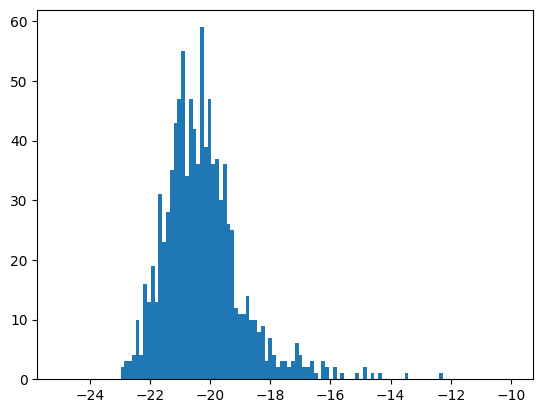

In [154]:
histM = plt.hist(schMr,bins=np.linspace(-25,-10,120))

Defining the the comoving volume function (Eales 1993)

In [125]:
def V(x):
    return ((1+x)**2 * np.sqrt(cosmo.Ode0 + cosmo.Om0 * (1+x)**3))**(-1)

In [131]:
integ,_ = sp.integrate.quad(lambda x:V(x), 0.001,sch_z_maxx)

In [ ]:
V_max = schsize*sch_c*sch_dl**2/cosmo.H0 * integ    # defining Vmax
V_inv = V_max**-1                                   # reaching the final state -> 1/Vmax

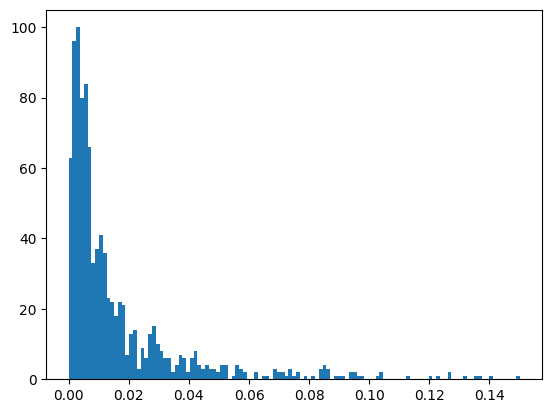

In [146]:
c, e = np.histogram(V_inv,bins=np.linspace(0,0.15,120))
histV = plt.hist(V_inv,bins=np.linspace(0,0.15,120))

In [153]:
counts, edges = np.histogram(schMr, bins=np.linspace(-25,-12,120))

Defining the luminosity function

In [62]:
from scipy.optimize import curve_fit

def func(x, M_star, alpha, phi):
    return 0.4*np.log(10)*phi*10**(-0.4*(1+alpha)*(x-M_star))*np.exp(-1*(10)**(-0.4*(x-M_star)))

In [ ]:
optedges = 0.5*(e[1:]+e[:-1])   #constructing bin from 1/Vmax
optedges1 = 0.5*(edges[1:]+edges[:-1]) #absmag values for plot at the bottom
coeffs, cov = curve_fit(func, optedges, c, p0=[-23, -1,0.0000001]) #fitting the Schechter function

/tmp/ipykernel_7260/1278976137.py:4: RuntimeWarning: overflow encountered in power
  return 0.4*np.log(10)*phi*10**(-0.4*(1+alpha)*(x-M_star))*np.exp(-1*(10)**(-0.4*(x-M_star)))


In [ ]:
coeffs, cov     #checking values

(array([-2.3e+01, -1.0e+00,  1.0e-07]),
 array([[ 3.85615040e+33, -3.58755054e+22,  8.62293597e+15],
        [-3.58755054e+22,  5.74634585e+12,  9.61117401e+06],
        [ 8.62293597e+15,  9.61117401e+06,  2.10875426e+01]]))

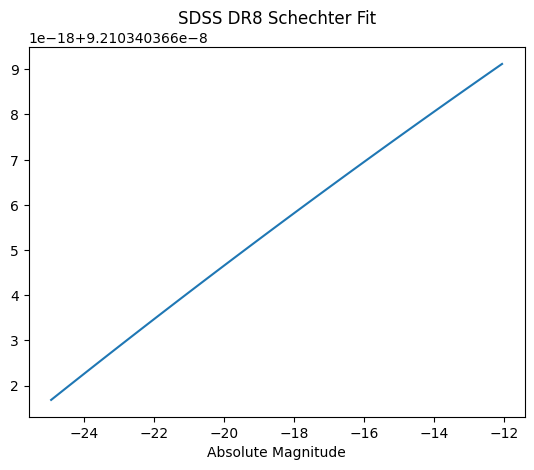

In [203]:
fig, ax = plt.subplots()
ax.plot(optedges1, func(optedges,*coeffs))
ax.set_xlabel('Absolute Magnitude')
ax.set_title('SDSS DR8 Schechter Fit')
plt.show()